In [2]:
print("hello world")

hello world


Kpart framwork

![image-20220923162817143](https://image.beenli.cn/image-20220923162817143.png?imageslim)
1. Kpart
   > 首先使用WhirlPool方法进行聚类(cluster)，然后使用lookahead方法进行分区(partition)
    1. WhirlPool
       - ![whirlpool1](https://image.beenli.cn/image-20220923163051032.png?imageslim)
       - ![whirlpool2](https://image.beenli.cn/image-20220923163126165.png?imageslim)
    2. lookahead
       - ![speedup curve](https://image.beenli.cn/image-20220923163746285.png?imageslim)
       - ![lookahead](https://image.beenli.cn/image-20220923163616768.png?imageslim)



## step1: 伪造miss曲线

In [3]:
way_nums = 12
application_nums = 6

import numpy as np
import random
miss_curve = np.zeros((application_nums, way_nums+1))
for app in range(application_nums):
    # 每个app一个随机数的种子
    random.seed(app)
    for alloc in range(way_nums+1):
        if alloc == 0:
            miss_curve[app][alloc] = 1
        else:
            miss_curve[app][alloc] = miss_curve[app][alloc-1] - random.uniform(0.01, 0.07)
# print(miss_curve)



## step2: 可视化每个application的miss curve

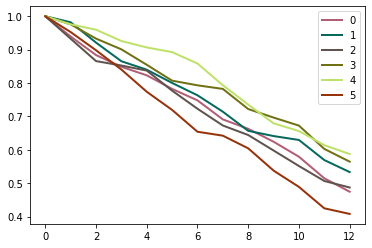

In [4]:
import matplotlib.pyplot as plt
X = list(range(way_nums+1))
for app in range(application_nums):
    plt.plot(X, miss_curve[app], label="%d" % app, c=np.random.rand(3,) ,linewidth=2)
plt.legend()

## step3: interpolate

In [5]:
# %pip install scipy
from scipy import interpolate
miss_curve_function = list()
for app in range(application_nums):
    f = interpolate.interp1d(X, miss_curve[app], kind="slinear")
    miss_curve_function.append(f)

## step4: get combineMissCurves

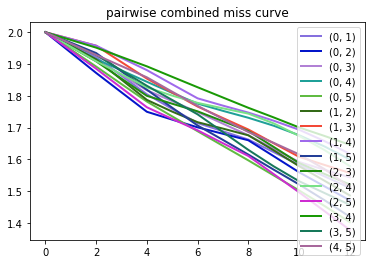

In [6]:

import itertools

pairwise = list(itertools.combinations(range(application_nums), 2))
"""
    m1 : function
    m2 : function
    return: np array
"""
def combineMissCurves(m1, m2):
    # print(m1, m2)
    m = np.zeros(way_nums+1)
    s1, s2 = 0, 0
    for s in range(way_nums+1):
        # print("s = {0}, s1 = {1}, s2 = {2}".format(s, s1, s2))
        m[s] =  m1(s1) + m2(s2)
        s1 += m1(s1) / m[s]
        s2 += m2(s2) / m[s]
    return m

combined_curve = np.zeros((len(pairwise), way_nums+1))


for index, pair in enumerate(pairwise):
    # print(index, pair)
    combined_curve[index] = combineMissCurves(miss_curve_function[pair[0]], miss_curve_function[pair[1]])
    plt.plot(X, combined_curve[index], label=str(pair), c =np.random.rand(3,), linewidth=2) 
    plt.title("pairwise combined miss curve")
    plt.legend()
# print(combined_curve)

CombinedMissCurve algorithm
- ![whirlpool2](https://image.beenli.cn/image-20220923163126165.png?imageslim)

## step5 get partition miss curve

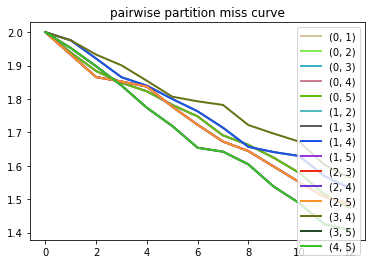

In [7]:
# using lookahead algorithm (for pairwise)

# 输入: 有多少个application, 分配多少way， 每个application的miss_curve 或者 IPC curve
# 输出: 每个application 分配多少个way
def lookahead(way_num, miss_curve):
    balance = way_num
    # print("application_list = {0}, miss_curve = {1} ".format(application_list, miss_curve))
    # print("len(miss_curve) = ", len(miss_curve))
    allocations = np.zeros(len(miss_curve))
    max_mu = np.zeros(len(miss_curve))
    blocks_req = np.zeros(len(miss_curve))
    while(balance):
        for index in range(len(miss_curve)):
            alloc = allocations[index]
            # print("get_mu_value(app, alloc, balance) app = {0}, alloc = {1}, balance = {2}".format(app, alloc, balance))
            max_mu[index], blocks_req[index] = get_max_mu(index, int(alloc), int(balance), miss_curve)
        max_mu_list = list(max_mu)
        winner = max_mu_list.index(max(max_mu_list))
        allocations[winner] += blocks_req[winner]
        balance -= blocks_req[winner]
    return allocations

def get_max_mu(p, alloc, balance, miss_curve):
    max_mu = 0
    for i in range(1, balance+1):
        mu = get_mu_value(p, alloc, alloc + i, miss_curve)
        if (mu > max_mu):
            max_mu = mu
    return max_mu, i 

def get_mu_value(p, a, b, miss_curve):
    # print("get_mu_value(p, a, b) p = {0}, a = {1}, b = {2}".format(p, a, b))
    return (miss_curve[p][a] - miss_curve[p][b])/(b - a)

# print(lookahead(2, (0, 1)))
def partitionMissCurves(pair):
    m = np.zeros(way_nums+1)
    for balance in range(way_nums+1):
        miss_curve_pair = [miss_curve[pair[0]], miss_curve[pair[1]]]
        alloc = lookahead(balance, miss_curve_pair)
        # print("lookahead(balance:{0}, pair:{1}) -> alloc:{2}".format(balance, pair, alloc))
        m[balance] = miss_curve_function[pair[0]](alloc[0])  + miss_curve_function[pair[1]](alloc[1])
    return m

partition_curve = np.zeros((len(pairwise), way_nums+1))

# for index, app in enumerate(("a", "b")):
#     print(index, app)
for index, pair in enumerate(pairwise):
    # print(index, pair)
    partition_curve[index] = partitionMissCurves(pair)
    plt.plot(X, partition_curve[index], label=str(pair), c =np.random.rand(3,), linewidth=2)
    plt.title("pairwise partition miss curve")
    plt.legend()
        

loopahead algorithm
- ![lookahead](https://image.beenli.cn/image-20220923163616768.png?imageslim)

## setp6:  get the distance for each app

In [8]:
def get_distance(pair_index, combined_curve, partition_curve):
    distance_list = []
    distance = 0
    for i in range(way_nums):
        distance_i = ((combined_curve[pair_index][i] - partition_curve[pair_index][i]) + (combined_curve[pair_index][i+1] - partition_curve[pair_index][i+1])) / 2 
        distance_list.append(distance_i) 
        distance += distance_i        
    return distance

for index, pair in enumerate(pairwise):
    # print(index, pair)
    print("distance for pair:{0}  is  {1} ".format(pair, get_distance(index, combined_curve, partition_curve)))
# pair: (1, 3)
# return: distance between cluster1 and cluster 3


distance for pair:(0, 1)  is  0.046416887379330474 
distance for pair:(0, 2)  is  -0.1492510286707167 
distance for pair:(0, 3)  is  0.20604938328216438 
distance for pair:(0, 4)  is  0.6529808163587838 
distance for pair:(0, 5)  is  -0.5076010041051449 
distance for pair:(1, 2)  is  0.12833731000650572 
distance for pair:(1, 3)  is  0.1737659607024442 
distance for pair:(1, 4)  is  0.6192124772709775 
distance for pair:(1, 5)  is  0.37281250845460123 
distance for pair:(2, 3)  is  0.28957872563670417 
distance for pair:(2, 4)  is  0.7415390774224089 
distance for pair:(2, 5)  is  -0.43128466242410823 
distance for pair:(3, 4)  is  0.39220010085962287 
distance for pair:(3, 5)  is  0.5398623055093442 
distance for pair:(4, 5)  is  0.9919025015193563 


## step7: cluster algorithm

In [10]:
def print_clusters(cluster_m):
    for index, cluster_member in enumerate(cluster_m):
        print("cluster{0} : {1}".format(index+1, cluster_member))

clusters_start = []
partition_start = []
way_nums = 12
application_nums = 6

import numpy as np
import random
miss_curve_start = np.zeros((application_nums, way_nums+1))
for app in range(application_nums):
    # 每个app一个随机数的种子
    random.seed(app)
    for alloc in range(way_nums+1):
        if alloc == 0:
            miss_curve_start[app][alloc] = 1
        else:
            miss_curve_start[app][alloc] = miss_curve_start[app][alloc-1] - random.uniform(0.01, 0.07)

# clustering
import sys
def hierarchy_cluster(pairwise_start, pairwise_distance, cluster, miss_curve, miss_curve_function):
    min_distance = sys.maxsize
    pairwise = (0, 0)
    for index, pair in enumerate(pairwise_start):
        if (abs(pairwise_distance[index]) < min_distance):
            min_distance = pairwise_distance[index]
            pairwise = pair
    print("cluster {0} and {1} -> merge ".format(pairwise[0]+1, pairwise[1]+1))
    result_cluster = []
    result_miss_curve = []
    for i in range(len(cluster)):
        if i == pairwise[0]:
            result_cluster.append(cluster[pairwise[0]] + cluster[pairwise[1]])
            result_miss_curve.append(combineMissCurves(miss_curve_function[pairwise[0]], miss_curve_function[pairwise[1]]))
        elif i == pairwise[1]:
            pass
        else:
            result_cluster.append(cluster[i])
            result_miss_curve.append(miss_curve[i])
    return result_cluster, result_miss_curve

print("========== the 0th interations in the cluster algorithm ============= ")
for app in range(application_nums):
    clusters_start.append([app])
print_clusters(clusters_start)

partition_start = lookahead(way_nums, miss_curve_start)
partition_final = [partition_start]

clusters_final = [clusters_start]

X = list(range(way_nums+1))  # partition size 
for intera in range(1, application_nums):
    cluster_i = clusters_start
    miss_curve = miss_curve_start
    import itertools
    for cluster in range(len(cluster_i)):
        f = interpolate.interp1d(X, miss_curve[cluster], kind="slinear")
        miss_curve_function.append(f)

    pairwise = list(itertools.combinations(range(len(cluster_i)), 2))
    pairwise_distance = []
    for index, pair in enumerate(pairwise):
        # print(index, pair)
        combined_curve[index] = combineMissCurves(miss_curve_function[pair[0]], miss_curve_function[pair[1]])
        partition_curve[index] = partitionMissCurves(pair)
        pairwise_distance.append(get_distance(index, combined_curve=combined_curve, partition_curve=partition_curve)) 
    
    print("========== after %d interations in the cluster algorithm ============= "% intera)
    clusters_start, miss_curve_start = hierarchy_cluster(pairwise, pairwise_distance, clusters_start, miss_curve, miss_curve_function)
    clusters_final.append(clusters_start)
    print_clusters(clusters_start)

========== the 0th interations in the cluster algorithm ============= 
cluster1 : [0]
cluster2 : [1]
cluster3 : [2]
cluster4 : [3]
cluster5 : [4]
cluster6 : [5]
========== after 1 interations in the cluster algorithm ============= 
cluster 1 and 2 -> merge 
cluster1 : [0, 1]
cluster2 : [2]
cluster3 : [3]
cluster4 : [4]
cluster5 : [5]
========== after 2 interations in the cluster algorithm ============= 
cluster 1 and 2 -> merge 
cluster1 : [0, 1, 2]
cluster2 : [3]
cluster3 : [4]
cluster4 : [5]
========== after 3 interations in the cluster algorithm ============= 
cluster 1 and 2 -> merge 
cluster1 : [0, 1, 2, 3]
cluster2 : [4]
cluster3 : [5]
========== after 4 interations in the cluster algorithm ============= 
cluster 1 and 2 -> merge 
cluster1 : [0, 1, 2, 3, 4]
cluster2 : [5]
========== after 5 interations in the cluster algorithm ============= 
cluster 1 and 2 -> merge 
cluster1 : [0, 1, 2, 3, 4, 5]


## step8 partition algorithm

In [ ]:
partitions_final = [[]]
for auto_cluster in clusters_final: